In [14]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS


from library import print_statistics

In [15]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, .005)
test

'9.16**'

In [16]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [17]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]

data.sample()

data['doi_year'] = np.where((data.doi_year == 2015), np.nan, data.doi_year) #drop first implementer (one district)

822


In [18]:
data.doi_year.value_counts()

2017.0    189602
2018.0     44254
2016.0     41794
2019.0      8971
Name: doi_year, dtype: int64

# Create year-test fixed effects

In [19]:
data['test_by_year'] = data['test'] + data['year'].map(str)

# Create trend and nonparametric variables

## Phase-in Effect - yearpost

In [20]:
data['yearpost'] = np.where(data.year > data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost']].sample(10)

,year,doi_year,yearpost
313944,2017,2016.0,1.0
129786,2017,2018.0,0.0
57715,2014,2017.0,0.0
161863,2019,2017.0,2.0
360251,2018,2016.0,2.0
220520,2013,2017.0,0.0
271532,2015,2017.0,0.0
163812,2019,2019.0,0.0
119460,2017,2017.0,0.0
192606,2012,2017.0,0.0


In [21]:
data.yearpost.value_counts()

0.0    217059
1.0     35318
2.0     29814
3.0      5491
Name: yearpost, dtype: int64

## Pretrends - yearpre

In [22]:
data['yearpre'] = np.where(data.year <= data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost', 'yearpre']].sample(5)

,year,doi_year,yearpost,yearpre
276693,2015,2017.0,0.0,-2.0
243986,2014,2017.0,0.0,-3.0
43782,2014,2018.0,0.0,-4.0
33551,2013,2019.0,0.0,-6.0
152142,2018,2017.0,1.0,0.0


In [23]:
data.yearpre.value_counts()

 0.0    110080
-1.0     36081
-2.0     35826
-3.0     35429
-4.0     34299
-5.0     28699
-6.0      6248
-7.0      1020
Name: yearpre, dtype: int64

## Non-parametric fixed effects for years pre and post - pre# and post#

In [24]:
data['pre5'] = np.where(data.yearpre <= -5, 1, 0)
data['pre4'] = np.where(data.yearpre == -4, 1, 0)
data['pre3'] = np.where(data.yearpre == -3, 1, 0)
data['pre2'] = np.where(data.yearpre == -2, 1, 0)
data['pre1'] = np.where(data.yearpre == -1, 1, 0)
data['pre0'] = np.where(data.yearpre == 0, 1, 0)
data['post1'] = np.where(data.yearpost == 1, 1, 0)
data['post2'] = np.where(data.yearpost == 2, 1, 0)
data['post3'] = np.where(data.yearpost == 3, 1, 0)


In [25]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = data.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5)

,,district,doi_year,treatpost
campus,year,,,
169911001,2014,169911,2017.0,False
227901007,2015,227901,2017.0,False
227901111,2017,227901,2017.0,False
91903041,2012,91903,2017.0,False
170902074,2016,170902,2016.0,False


# Specifications

In [26]:
# Get table ready
file = table_path + 'table3_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active

## Simple GDID

In [27]:
test = pd.Categorical(df.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2305
Estimator:                   PanelOLS   R-squared (Between):             -0.1469
No. Observations:              287682   R-squared (Within):               0.2305
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.0287
Time:                        12:53:57   Log-likelihood                -2.137e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      577.28
Entities:                        6117   P-value                           0.0000
Avg Obs:                       47.030   Distribution:              F(146,281419)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             299.54
                            

## GDID with Trends

In [61]:
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
#mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
preslope_se = res.std_errors['yearpre']
postslope = res.params['yearpost']
post_slope = res.std_errors['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2306
Estimator:                   PanelOLS   R-squared (Between):             -0.1472
No. Observations:              287682   R-squared (Within):               0.2306
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.0284
Time:                        13:26:01   Log-likelihood                -2.137e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      569.82
Entities:                        6117   P-value                           0.0000
Avg Obs:                       47.030   Distribution:              F(148,281417)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             297.19
                            

In [42]:
mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2306
Estimator:                   PanelOLS   R-squared (Between):             -0.1473
No. Observations:              287682   R-squared (Within):               0.2306
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.0284
Time:                        13:11:13   Log-likelihood                -2.137e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      551.31
Entities:                        6117   P-value                           0.0000
Avg Obs:                       47.030   Distribution:              F(153,281412)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             287.36
                            

In [48]:
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1,0 , 1, 2, 3]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df

,coef,err,year,lb,ub
0,-0.003365,0.035743,-5,-0.073421,0.066692
1,0.001784,0.028955,-4,-0.054968,0.058536
2,0.017792,0.022878,-3,-0.027048,0.062633
3,0.014149,0.016128,-2,-0.017461,0.045760
4,0.004130,0.008933,-1,-0.013379,0.021639
5,0.000000,0.000000,0,0.000000,0.000000
6,-0.020996,0.009650,1,-0.039909,-0.002082
7,-0.047298,0.018603,2,-0.083761,-0.010835
8,-0.073740,0.028855,3,-0.130297,-0.017184


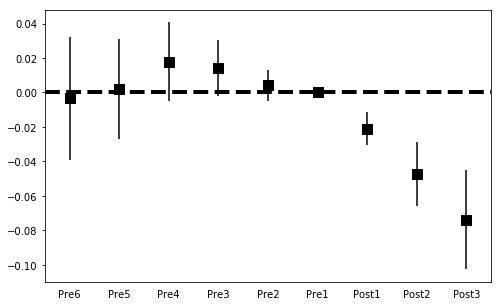

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre6', 'Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

# Create graph (look up how to use predicted values)


In [59]:
years = [-5, -4, -3, -2, -1, 0, 1, 2, 3]
parametric = []
parametric_lb = []
for year in years:
    par = 0
    if year < 0 :
        par = (year * preslope)
    if year > 0 :
        par = jump + (year * postslope)
    parametric.append(par)
parametric

[-0.0377641241123379,
 -0.03021129928987032,
 -0.02265847446740274,
 -0.01510564964493516,
 -0.00755282482246758,
 0,
 -0.01684542161162881,
 -0.037000019103722255,
 -0.0571546165958157]

In [60]:
nonparametric

[-0.0033647748971516317,
 0.001783793278973142,
 0.017792489765217787,
 0.0141492391135295,
 0.004129992631403456,
 0,
 -0.020995511535623818,
 -0.047298032838930304,
 -0.07374038689628312]

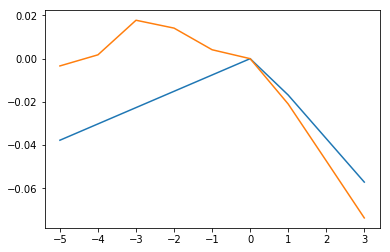

In [71]:
plt.plot(years, parametric)
plt.plot(years, nonparametric)

# Table by Subject

In [71]:
df.test.value_counts()

m_3rd_avescore    25746
r_3rd_avescore    25742
m_4th_avescore    25579
r_4th_avescore    25574
r_5th_avescore    23519
m_5th_avescore    23518
alg_avescore      17898
m_6th_avescore    13315
r_6th_avescore    13042
m_7th_avescore    11351
r_8th_avescore    11311
s_8th_avescore    11297
m_8th_avescore    11284
r_7th_avescore    11230
eng1_avescore     10454
bio_avescore      10072
eng2_avescore      8912
us_avescore        7838
Name: test, dtype: int64

In [72]:
def subject_table(df, test, workbook):

    file = table_path + workbook
    wb = load_workbook(file)
    ws = wb.active
    df = df[df.test == test]

    test = pd.Categorical(df.test)
    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)
    ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
    #mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)
    #intercept = res.params['Intercept']
    jump = res.params['treatpost[T.True]']
    preslope = res.params['yearpre']
    preslope_se = res.std_errors['yearpre']
    postslope = res.params['yearpost']
    post_slope = res.std_errors['yearpost']
    ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
    ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
    ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
    wb.save(file)

    mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre0':
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    print(nonparametric)
    row = 3
    for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
        ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
        row = row + 1
    wb.save(file)

## Algebra

In [74]:
subject_table(df, 'alg_avescore', 'table3_gdid_and_event_algebra.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.3927
Estimator:                   PanelOLS   R-squared (Between):              0.0057
No. Observations:               17898   R-squared (Within):               0.3927
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.0618
Time:                        13:39:28   Log-likelihood                   -4946.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      993.14
Entities:                        6116   P-value                           0.0000
Avg Obs:                       2.9264   Distribution:                F(10,15357)
Min Obs:                       0.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             350.87
                            

In [75]:
subject_table(df, 'm_5th_avescore', 'table3_gdid_and_event_math_5th.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.3345
Estimator:                   PanelOLS   R-squared (Between):              0.0678
No. Observations:               23518   R-squared (Within):               0.3345
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.1421
Time:                        13:39:57   Log-likelihood                -1.377e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1020.4
Entities:                        6117   P-value                           0.0000
Avg Obs:                       3.8447   Distribution:                F(10,20297)
Min Obs:                       0.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             447.42
                            

In [76]:
subject_table(df, 'r_5th_avescore', 'table3_gdid_and_event_ela_5th.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2055
Estimator:                   PanelOLS   R-squared (Between):              0.2050
No. Observations:               23519   R-squared (Within):               0.2055
Date:                Sat, Dec 14 2019   R-squared (Overall):              0.2098
Time:                        13:41:06   Log-likelihood                -1.045e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      525.15
Entities:                        6117   P-value                           0.0000
Avg Obs:                       3.8449   Distribution:                F(10,20299)
Min Obs:                       0.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             389.50
                            

# Heterogenous effects

In [ ]:
### Generate variable for number of hispanic students in year before the district declares

In [ ]:
data.teachers_turnover_ratio_d

In [ ]:
data_pre = data.loc[data.yearpost == -1]
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teacher_turnover_pre'})
data_pre['low_avescores_pre'] = np.where(data_pre.avescores < data_pre.avescores.quantile(.25),1, 0)
data_pre['high_avescores_pre'] = np.where(data_pre.avescores > data_pre.avescores.quantile(.75),1,0)
data_pre = data_pre[['campus','students_hisp_pre', 'teacher_turnover_pre', 'low_avescores_pre', 'high_avescores_pre']]
data_hte = data.merge(data_pre, on = 'campus', how = 'left')
data_hte['majority_hisp_pre'] = np.where(data_hte.students_hisp_pre > .6, 1, 0)
data_hte['high_turnover'] = np.where(data_hte.teacher_turnover_pre > 20, 1, 0)
data_hte

In [ ]:
data_pre = data.loc[data.year == 2016]
data_pre['rural_pre'] = np.where(data_pre.type_description == "RURAL", 1, 0)
data_pre['urban_pre'] = np.where(data_pre.type_description == "URBAN", 1, 0)
data_pre = data_pre[['campus','rural_pre', 'urban_pre']]
data_hte = data_hte.merge(data_pre, on = 'campus', how = 'left')
#df_hte[['students_hisp', 'students_hisp_pre', 'yearpost']].sample(5)

In [ ]:
#convert year to datetime
df_hte = data_hte.reset_index()
df_hte['year'] = pd.to_datetime(df_hte['year'], format='%Y')
#add column year to index
df_hte = data_hte.set_index(['year', 'campus'])
#swap indexes
df_hte.index = df_hte.index.swaplevel(0,1)
df_hte[['district', 'doi_year','treatpost',]].tail(20)

# Majority Hispanic

In [ ]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + students_hisp + students_num + C(test) + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [ ]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
df_hte['treatpost_hisp_rural'] = df_hte.treatpost_hisp * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + treatpost_hisp_rural + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [ ]:
df_hte[df_hte.majority_hisp_pre == 1][['district', 'type_description', 'majority_hisp_pre']]

# Rural

In [ ]:
df_hte['treatpost_rural'] = df_hte.treatpost * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_rural + rural_pre +  students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

# Performance

In [ ]:
df_hte['treatpost_low'] = df_hte.treatpost * df_hte.low_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_low + students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [ ]:
df_hte['treatpost_high'] = df_hte.treatpost * df_hte.high_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_high+ students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

# Teacher Turnover

In [ ]:
df_hte['treatpost_turnover'] = df_hte.treatpost * df_hte.high_turnover
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_turnover + students_hisp + students_num + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)